README
--

These are *approximate* analytics based on (fallible) automated detection of different contract types. Do note that the analysis listed in the paper was done after filtering out false positive ERC-20 contracts from this list. That analysis can be found in the [linktree](https://linktr.ee/tethersurvey) under **ERC-20 Contract Analysis**

This notebook includes function name string match-based autodetection of the *contract pause*, *user blacklist* and *contract upgrade* features mentioned in the paper. However, the matches were further filtered to those that matched **actual** ERC-20 contracts outside of this notebook before being reported in the paper.

In [1]:
import json
import os
import re
import functools
from collections import Counter
from glob import glob
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from zeppelin_contracts import ZEPPELIN_CONTRACTS

from typing import Any, Callable, Dict, List, Tuple, Union

mpl.rcParams['figure.figsize'] = (10,7)

In [2]:
SOURCE_CODE_DIR = './source-code'
TOP_N_DATA_PATH = './data/top-500-minblock-14434001-maxblock-15012398.feather'

FN_NAMES_TEMP_PARSE_PATH = './tmp/parse/parsed.json'
FN_NAMES_TEMP_FILE_PATH = './tmp/parse/file.sol'

In [3]:
os.makedirs(os.path.dirname(FN_NAMES_TEMP_PARSE_PATH), exist_ok=True)

# Code class

In [4]:
class Code:
    def __init__(self, path: str) -> None:
        self.path = path
        self.name = ''.join( os.path.basename(path).split('_')[:-1] )
        self.address = os.path.basename(path).split('_')[-1].replace('.sol', '')
        
        with open(path) as f:
            self.src = self._process_source(f.read())
        self.lines = self.src.split('\n')
        self.comment_lines, self.noncomment_lines = self._seperate_comments()
        self.fn_names = self._extract_fn_names()
            
        self.contracts = set([l.split()[1] for l in self.lines if l.startswith('contract')])
        self.interfaces = set([l.split()[1] for l in self.lines if l.startswith('interface')])
        self.libraries = set([l.split()[1] for l in self.lines if l.startswith('library')])
        self.zeppelin_contracts = self.contracts.intersection(ZEPPELIN_CONTRACTS)
        
        self.is_erc20 = self.contains_part('erc20')
        self.is_erc721 = self.contains_part('erc721')
        self.is_erc1155 = self.contains_part('erc1155')
        
    def _process_source(self, content: str) -> str:
        """Handles the dict-like case as well as normal case"""
        
        def concat_sources_content(sources: dict) -> str:
            items = []
            for name, values in sources.items():
                items.append('// FILE: ' + name)
                items.append(values['content'])

            return '\n'.join(items)
        
        if content[0] == '{':
            if content[1] == '{':
                srcs = json.loads(content[1:-1])['sources']
            else:
                srcs = json.loads(content)
            return concat_sources_content(srcs)
        return content
    
    def _extract_fn_names(self) -> None:
        """Extract function names"""
        
        def visit(curr: Any, visitor_fn: Callable[[Dict], Any]):
            if isinstance(curr, dict):
                visitor_fn(curr)
                for k in curr:
                    visit(curr[k], visitor_fn)
            elif isinstance(curr, list):
                for v in curr:
                    visit(v, visitor_fn)

        def visitor(d: dict) -> None:
            if 'type' in d and d['type'] == 'FunctionDefinition':
                fnames.append(d['name'])

        
        with open(FN_NAMES_TEMP_FILE_PATH, 'w') as f:
            f.write(self.src)
            
        os.system(f'surya parse -j {FN_NAMES_TEMP_FILE_PATH} | jq > {FN_NAMES_TEMP_PARSE_PATH}')

        fnames = []
        with open(FN_NAMES_TEMP_PARSE_PATH) as f:
            data = json.load(f)

        visit(data, visitor) # retrieve function names
        return fnames 
        
        
    def _seperate_comments(self) -> Tuple[str, str]:
        """ Returns (comment_lines, noncomment_lines) each in list format
        """
        
        multiline_pattern = re.compile('/\*.+?\*/', re.DOTALL)
        multiline_comments = re.findall(multiline_pattern, self.src)
        
        singleline_pattern = re.compile('\s*//.*')
        singleline_comments = re.findall(singleline_pattern, self.src)
        
        multiline_comment_lines = []
        for mc in multiline_comments:
            multiline_comment_lines.extend(mc.split('\n'))
            
        comment_lines = multiline_comment_lines + singleline_comments
        noncomment_lines = functools.reduce(
            lambda s, p: re.sub(p, '', s),
            [multiline_pattern, singleline_pattern],
             self.src
         ).split('\n')
        
        return (
            comment_lines,
            noncomment_lines
        )
        
    def to_record(self) -> Dict[str, Union[str, int]]:
        return {
            'name': self.name,
            
            'contracts': self.contracts,
            'num_contracts': len(self.contracts),
            
            'interfaces': self.interfaces,
            'num_interfaces': len(self.interfaces),
            
            'libraries': self.contracts,
            'num_libraries': len(self.contracts),
            
            'num_lines': len(self.lines),
            'num_comment_lines': len(self.comment_lines),
            'num_noncomment_lines': len(self.noncomment_lines),
            
            'is_erc20': self.is_erc20,
            'is_erc721': self.is_erc721,
            'is_erc1155': self.is_erc1155,
        }
    
    def contains_part(self, partial_match: str, verbose_contracts=False, verbose_interfaces=False) -> bool:
        """Check if any contract name or implemented interface contains partial match (case-insensitive)."""
        
        contract_matches = re.findall(partial_match, '|'.join(self.contracts).lower())
        
        interface_matches = re.findall('contract .+? is (.+'+partial_match+').+{?', self.src, flags=re.IGNORECASE)
        
        if len(contract_matches) or len(interface_matches):
            if verbose_contracts and len(contract_matches):
                print('\tContracts: ' + ' | '.join(self.contracts))
            if verbose_interfaces and len(interface_matches):
                print('\tInterfaces: ' + '\n'.join(interface_matches))
            return True
        
        return False
                                
    @classmethod
    def load_from_dir(cls, dirpath) -> List['Code']:
        codes = []
        num_errors = 0
        for p in tqdm(glob(os.path.join(dirpath, '*.sol'))):
            if os.path.isdir(p):
                continue
            try:
                codes.append(Code(p))
            except:
                num_errors += 1
            
        
        print(f'{len(codes)} codes loaded, {num_errors} failed.')
        
        return codes
    
    def __repr__(self):
        return f'{self.name}: {len(self.lines)} lines, {len(self.contracts)} contracts ({self.contracts})'

# Load Data

In [ ]:
most_freq = pd.read_feather(TOP_N_DATA_PATH)
most_freq_addresses = set(most_freq.Address.tolist())

codes = Code.load_from_dir(SOURCE_CODE_DIR)
codes = [c for c in codes if c.address in most_freq_addresses]
codes_df = pd.DataFrame.from_records(c.to_record() for c in codes).sort_values('num_contracts', ascending=False)
codes_df.head()
print(f'After filtering to most freq sent to, {len(codes)} files remain')

# Stats

In [15]:
num_zeppelin = 0
num_contracts = 0
num_has_zeppelin = 0
num_erc20 = 0
num_erc721 = 0
num_erc1155 = 0

for code in codes:
    num_zeppelin += len(code.contracts.intersection(ZEPPELIN_CONTRACTS))
    num_contracts += len(code.contracts)
    num_has_zeppelin += len(code.contracts.intersection(ZEPPELIN_CONTRACTS)) > 0
    num_erc20 += code.is_erc20
    num_erc721 += code.is_erc721
    num_erc1155 += code.is_erc1155
    
    
print(f'Mean of {num_zeppelin/len(codes):.2f} zeppelin contracts (total {num_zeppelin}) in {len(codes)} code files')
print(f'Mean of {num_contracts/len(codes):.2f} contracts (total {num_contracts}) in {len(codes)} code files')
print(f'{num_has_zeppelin}/{len(codes)} files ({num_has_zeppelin/len(codes)*100:.2f}%) have zeppelin')
print(f'{num_zeppelin/num_contracts*100:.1f}% of contracts are zeppelin')
print()
print(f'{num_erc20/len(codes)*100:.1f}% (total {num_erc20}) of contracts have ERC-20 references')
print(f'{num_erc721/len(codes)*100:.1f}% (total {num_erc721}) of contracts have ERC-721 references')
print(f'{num_erc1155/len(codes)*100:.1f}% (total {num_erc1155}) of contracts have ERC-1155 references')

Mean of 0.83 zeppelin contracts (total 305) in 366 code files
Mean of 3.98 contracts (total 1456) in 366 code files
201/366 files (54.92%) have zeppelin
20.9% of contracts are zeppelin

28.4% (total 104) of contracts have ERC-20 references
35.5% (total 130) of contracts have ERC-721 references
3.6% (total 13) of contracts have ERC-1155 references


# Process into dataframe

In [16]:
dicts = []
for code in codes:
    num_contracts = len(code.contracts)
    has_zeppelin = len(code.contracts.intersection(ZEPPELIN_CONTRACTS)) > 0
    dicts.append({
        'ContractName': code.name,
        'Address': code.address,
        'num_contracts': num_contracts,
        'contracts': code.contracts,
        'is_erc20': code.is_erc20,
        'is_erc721': code.is_erc721,
        'is_erc1155': code.is_erc1155,
        'src': code.src,
        'path': code.path,
        'fn_names': code.fn_names,
    })
df = pd.DataFrame.from_dict(dicts) 
df = df.merge(most_freq, on=['ContractName', 'Address'], how='right')
df = df.sort_values('num_tx', ascending=False).reset_index()
df['frac_tx'] = df['num_tx'] / df['num_tx'].sum()

In [17]:
for c in ['20', '721', '1155']:
    df[f'is_erc{c}'] = df[f'is_erc{c}'].fillna(False)
df[df.is_erc1155].frac_tx.sum()

0.009037228556936576

# Transactions for Tokens

## ERC20

In [18]:
is_erc20 = df[df.is_erc20]
is_erc20['frac_tx'] = is_erc20['num_tx'] / is_erc20['num_tx'].sum()

is_erc20['cumsum_frac'] = is_erc20.frac_tx.cumsum()
is_erc20['rank'] = list(range(1, 1+len(is_erc20)))
(is_erc20.num_tx.sum()) / df.num_tx.sum()

/var/folders/k8/zk3t1hw970s24hcwklx_31ww0000gn/T/ipykernel_12000/2595829981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_erc20['frac_tx'] = is_erc20['num_tx'] / is_erc20['num_tx'].sum()
/var/folders/k8/zk3t1hw970s24hcwklx_31ww0000gn/T/ipykernel_12000/2595829981.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_erc20['cumsum_frac'] = is_erc20.frac_tx.cumsum()
/var/folders/k8/zk3t1hw970s24hcwklx_31ww0000gn/T/ipykernel_12000/2595829981.py:5: SettingWithCopyWarning: 
A value is trying to be set o

0.373681266731742

In [19]:
def check_fn_names(df: pd.DataFrame, matches: List[str]) -> pd.Series:
    """Check dataframe with fn_names column for match (case-insensitive)"""
    
    fn_names_lower = df.fn_names.apply(lambda x: str([v.lower() for v in x if v]))
    curr = fn_names_lower.str.contains(matches[0])
    for match in matches[1:]:
        curr = curr | fn_names_lower.str.contains(match)
    return curr

IS_PAUSABLE = 'is_pausable'
IS_BLACKLISTABLE = 'is_blacklistable'
IS_UPGRADABLE = 'is_upgradable'

# PAUSABLE_MATCHES = ['pause', 'pausable', 'stop']
PAUSABLE_MATCHES = ['paus']
BLACKLISTABLE_MATCHES = ['blacklist']
UPGRADABLE_MATCHES = ['deprecat']
    
is_erc20[IS_PAUSABLE] = check_fn_names(is_erc20, PAUSABLE_MATCHES)
is_erc20[IS_BLACKLISTABLE] = check_fn_names(is_erc20, BLACKLISTABLE_MATCHES)
is_erc20[IS_UPGRADABLE] = check_fn_names(is_erc20, UPGRADABLE_MATCHES)

features = [IS_PAUSABLE, IS_BLACKLISTABLE, IS_UPGRADABLE]
display(f'{len(is_erc20)} ERC-20 contracts')
is_erc20[features].sum()

/var/folders/k8/zk3t1hw970s24hcwklx_31ww0000gn/T/ipykernel_12000/3350499792.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_erc20[IS_PAUSABLE] = check_fn_names(is_erc20, PAUSABLE_MATCHES)
/var/folders/k8/zk3t1hw970s24hcwklx_31ww0000gn/T/ipykernel_12000/3350499792.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_erc20[IS_BLACKLISTABLE] = check_fn_names(is_erc20, BLACKLISTABLE_MATCHES)
/var/folders/k8/zk3t1hw970s24hcwklx_31ww0000gn/T/ipykernel_12000/3350499792.py:21: SettingWithCopyWarning: 
A 

'102 ERC-20 contracts'

is_pausable         20
is_blacklistable     2
is_upgradable        1
dtype: int64

In [20]:
features_df = (
    is_erc20
    # [
    #     is_erc20['is_pausable']
    #     | is_erc20['is_blacklistable']
    #     | is_erc20['is_upgradable']
    # ]
    [['rank', 'ContractName', 'is_pausable', 'is_blacklistable', 'is_upgradable', 'Address']]
)
features_df.to_csv('./data/erc20_with_features.csv')

In [21]:
import shutil

DIR = 'tmp/erc20'
if os.path.exists(DIR):
    shutil.rmtree(DIR)
os.makedirs(DIR, exist_ok=True)

for code in is_erc20.itertuples():
    path = os.path.join(DIR, str(code.rank).zfill(3) + '_' + os.path.basename(code.path))
    print(path)
    with open(path, 'w') as f:
        f.write(code.src)

tmp/erc20/001_TetherToken_0xdAC17F958D2ee523a2206206994597C13D831ec7.sol
tmp/erc20/002_WyvernExchangeWithBulkCancellations_0x7f268357A8c2552623316e2562D90e642bB538E5.sol
tmp/erc20/003_MetaSwap_0x881D40237659C251811CEC9c364ef91dC08D300C.sol
tmp/erc20/004_TokenMintERC20Token_0x95aD61b0a150d79219dCF64E1E6Cc01f0B64C4cE.sol
tmp/erc20/005_SimpleToken_0x4d224452801ACEd8B2F0aebE155379bb5D594381.sol
tmp/erc20/006_KOKContract_0x9B9647431632AF44be02ddd22477Ed94d14AacAa.sol
tmp/erc20/007_MaticToken_0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0.sol
tmp/erc20/008_WyvernProxyRegistry_0xa5409ec958C83C3f309868babACA7c86DCB077c1.sol
tmp/erc20/009_Gala_0x15D4c048F83bd7e37d49eA4C83a07267Ec4203dA.sol
tmp/erc20/010_LinkToken_0x514910771AF9Ca656af840dff83E8264EcF986CA.sol
tmp/erc20/011_ZeroEx_0xDef1C0ded9bec7F1a1670819833240f027b25EfF.sol
tmp/erc20/012_WrappedLuna_0xd2877702675e6cEb975b4A1dFf9fb7BAF4C91ea9.sol
tmp/erc20/013_MANAToken_0x0F5D2fB29fb7d3CFeE444a200298f468908cC942.sol
tmp/erc20/014_CroToken_0xA0b73E

### Check features

NameError: name 'checks' is not defined

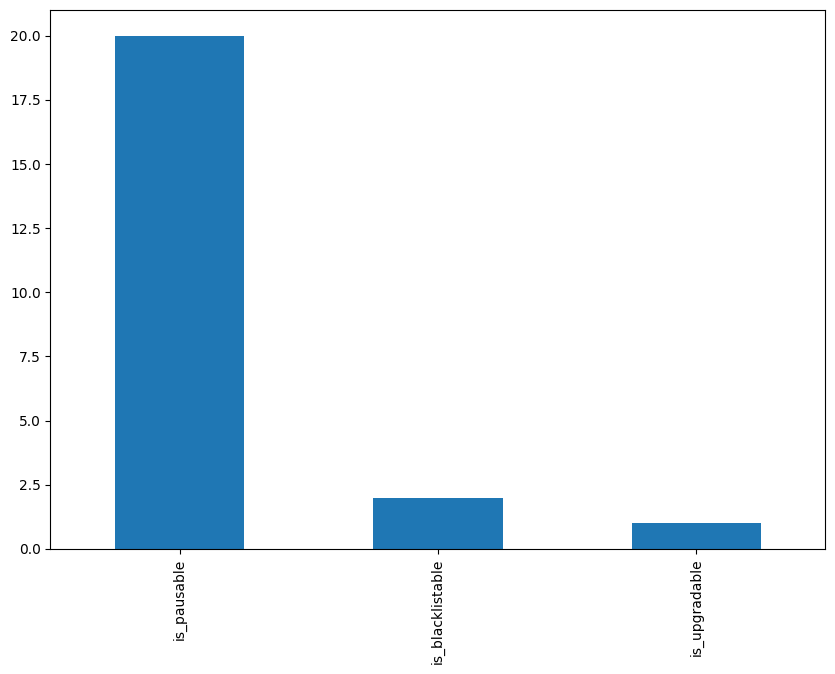

In [14]:
is_erc20[features].sum().plot.bar()
is_erc20[features].value_counts(normalize=True).reset_index(name='frac_contracts').sort_values(checks, ascending=False)
is_erc20[features].value_counts(normalize=False).reset_index(name='num_contracts').sort_values(checks, ascending=False)

In [ ]:
df2 = is_erc20.head(5)
df2[checks].value_counts(normalize=True).reset_index(name='frac_contracts').sort_values(checks, ascending=False)

In [ ]:
df2 = is_erc20
cumsum_frac = df2.num_tx.cumsum()
cumsum_frac = cumsum_frac/cumsum_frac.max()
cumsum_frac.name = 'Fraction of transactions'

fig, _ = plt.subplots(figsize=(20, 8))
g = sns.barplot(df2.ContractName, cumsum_frac)
plt.xticks(rotation=90);

In [ ]:
is_erc20.head(30)[['rank', 'ContractName', 'frac_tx'] + features]

## ERC-721

In [ ]:
df[df.is_erc721].num_tx.sum() / df.num_tx.sum()

## ERC-1155

In [ ]:
df[df.is_erc1155].num_tx.sum() / df.num_tx.sum()

## Looking through ERC-20

In [ ]:
is_erc20.reset_index()

In [ ]:
# import shutil


# os.listdir(DATA_DIR)
# for r in is_erc20.itertuples():
#     fname = f'{r.ContractName}_{r.Address}.sol'
#     shutil.copyfile(
#         os.path.join(DATA_DIR, fname),
#         os.path.join(DATA_DIR, 'ERC20 Tokens', fname),
#     )
    
l = [
    'CroToken_0xA0b73E1Ff0B80914AB',
    'SmoothLovePotion_0xCC8Fa225D8',
    'MaticToken_0x7D1AfA7B718fb893',
    'BalancerGovernanceToken_0xba1',
    'BalancerGovernanceToken_0xba1',
    'IMXToken_0xF57e7e7C23978C3cAE',
    'HEX_0x2b591e99afE9f32eAA6214f',
    'L1BridgeZap_0x6571d6be3d8460C',
    'JasmyCoin_0x7420B4b9a0110cdC7',
    'OneInch_0x111111111117dC0aa78',
    'Dogelon_0x761D38e5ddf6ccf6Cf7',
    'SushiToken_0x6B3595068778DD59',
    'Hedron_0x3819f64f282bf135d621',
    'TokenMintERC20Token_0x95aD61b',
    'chiliZ_0x3506424F91fD33084466',
    'Coti_0xDDB3422497E61e13543BeA',
    'DydxToken_0x92D6C1e31e14520e6',
    'FTT_0x50D1c9771902476076eCFc8',
    'Lynkey_0xef952363C1d990A2fa58',
    'SatoshiStaking_0x374FCAF484cd',
    'WBTC_0x2260FAC5E5542a773Aa44f',
    'AXSToken_0xBB0E17EF65F82Ab018',
    'GenericToken_0x476c5E26a75bd2',
    'YFI_0x0bc529c00C6401aEF6D220B',
    'SocialGoodToken_0xdDF7Fd345D5',
    'ConvexToken_0x4e3FBD56CD56c3e',
    'StandardERC20_0xf3b9569F82B18',
    'ACH_0xEd04915c23f00A313a54495',
    'OriginToken_0x8207c1FfC5B6804',
    'GraphToken_0xc944E90C64B2c076',
    'PulseDogecoin_0x34F0915a5f15a',
]
l = set([f.split('_')[0] for f in l])
cs = is_erc20.ContractName
cs[~cs.isin(l)]

# Most repeated libraries
Intent: Search for common libraries

In [22]:
counter = Counter([])
for c in codes:
    counter.update(c.libraries)
counter.most_common(10)

[('Address', 218),
 ('Strings', 134),
 ('SafeMath', 98),
 ('MerkleProof', 70),
 ('ECDSA', 46),
 ('SafeERC20', 42),
 ('StorageSlot', 25),
 ('Counters', 24),
 ('EnumerableSet', 16),
 ('TransferHelper', 12)]

# Most repeated contract names

In [25]:
counter = Counter([])
for c in codes:
    counter.update(set(c.contracts))
counter.most_common(20)

[('ERC20', 77),
 ('ERC721A', 68),
 ('ERC721', 48),
 ('Ownable', 38),
 ('TransparentUpgradeableProxy', 27),
 ('AdminUpgradeabilityProxy', 24),
 ('ERC1967Proxy', 23),
 ('StandardToken', 19),
 ('ERC20Basic', 17),
 ('ProxyAdmin', 17),
 ('ChildOfProxiable', 17),
 ('BasicToken', 15),
 ('Proxy', 14),
 ('Pausable', 14),
 ('Owned', 13),
 ('UpgradeabilityProxy', 11),
 ('UpgradeableProxy', 10),
 ('ERC1155', 10),
 ('ERC20Detailed', 10),
 ('MintableToken', 8)]

# How complex is the code? Num noncomment lines
IMPT: Haven't stripped out empty (whitespace) lines

<Axes: xlabel='num_noncomment_lines', ylabel='Count'>

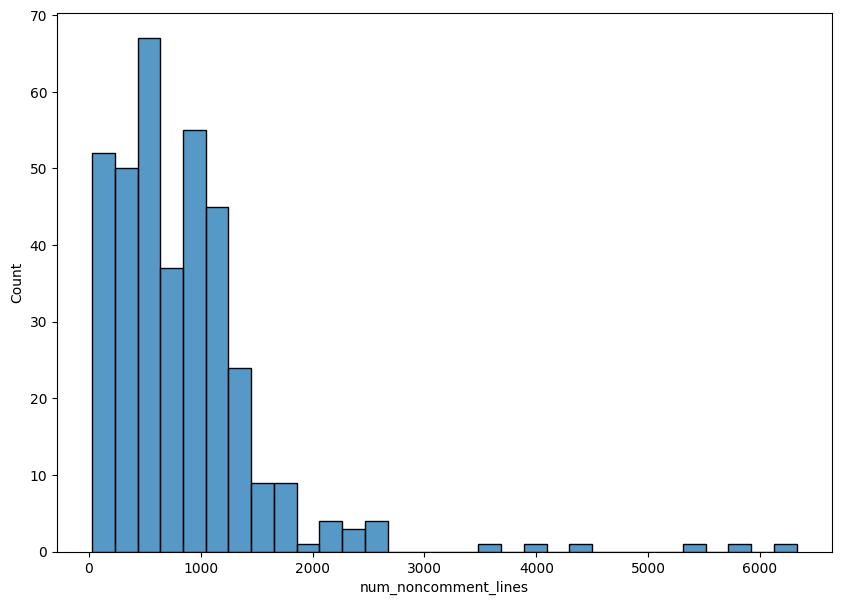

In [26]:
sns.histplot(codes_df.num_noncomment_lines)

# How complex is the code? Num contracts

<Axes: xlabel='num_contracts', ylabel='Count'>

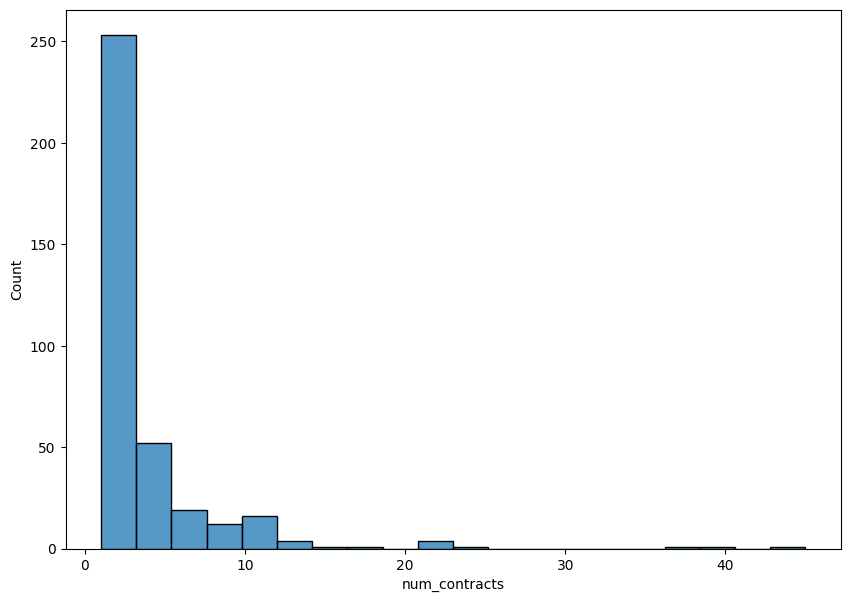

In [27]:
sns.histplot(codes_df.num_contracts, bins=20)

# How well commented is it?
% of lines being comment lines

Text(0.5, 0, 'Fraction of lines are comment lines')

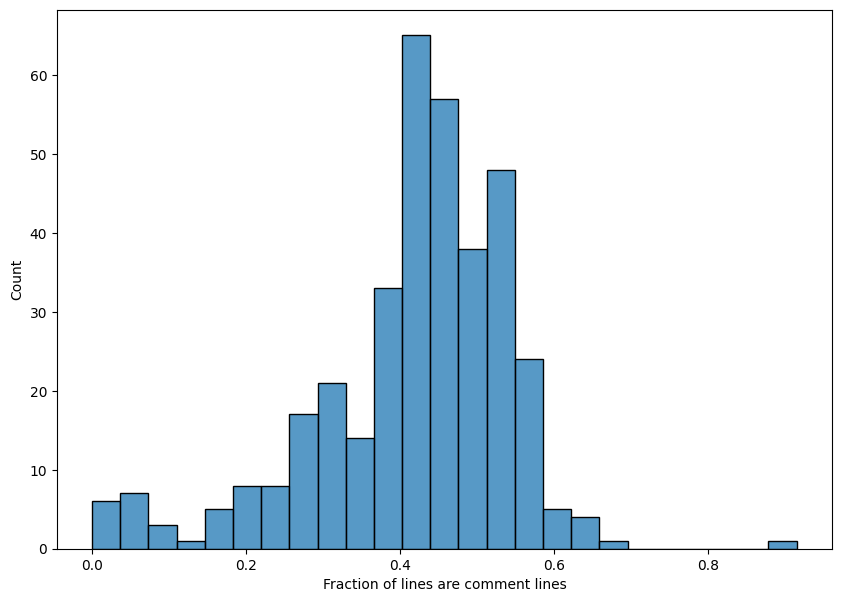

In [28]:
sns.histplot(
    codes_df.num_comment_lines / codes_df.num_lines,
).set_xlabel('Fraction of lines are comment lines')

/var/folders/k8/zk3t1hw970s24hcwklx_31ww0000gn/T/ipykernel_12000/1466903021.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


Text(0.5, 0, 'Fraction of lines are comment lines')

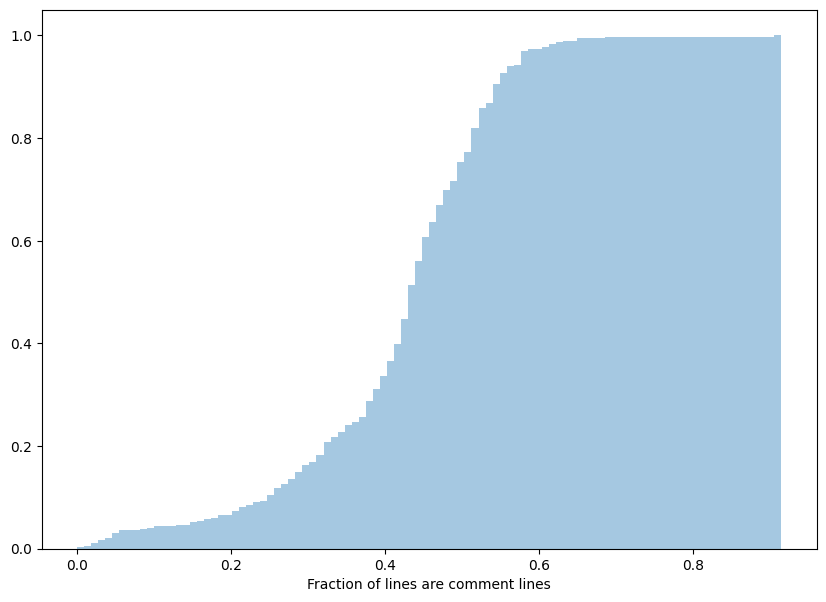

In [29]:
sns.distplot(
    codes_df.num_comment_lines / codes_df.num_lines,
    kde=False,
    hist_kws={'cumulative': True, 'density': True},
    bins=100
).set_xlabel('Fraction of lines are comment lines')

In [30]:
pd.set_option('display.max_rows', 30)
mf = most_freq[['ContractName', 'num_tx', 'Address']]
mf = mf[mf.ContractName != ''].reset_index().drop(columns=['index'])
mf = mf.reindex().reset_index().rename(columns={'index': 'rank'})
mf['rank'] += 1
mf['perc_tx_of_most_used'] = mf.num_tx / mf.num_tx.sum() * 100
mf

,rank,ContractName,num_tx,Address,perc_tx_of_most_used
0,1,TetherToken,6620945,0xdAC17F958D2ee523a2206206994597C13D831ec7,16.238425
1,2,WyvernExchangeWithBulkCancellations,6169327,0x7f268357A8c2552623316e2562D90e642bB538E5,15.130794
2,3,SwapRouter02,3408742,0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45,8.360227
3,4,FiatTokenProxy,2910886,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,7.139193
4,5,WETH9,1725091,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,4.230931
...,...,...,...,...,...
363,364,EverdomeNFTClaim,12646,0xcc0A99F59e7b153bad42f54C278C16E4081Afa7C,0.031015
364,365,mcgoblintownwtf,12646,0xc5B52253f5225835cc81C52cdb3d6A22bc3B0c93,0.031015
365,366,GODS,12643,0xccC8cb5229B0ac8069C51fd58367Fd1e622aFD97,0.031008
366,367,Akuma,12572,0xFA7E3F898c80E31A3aedeAe8b0C713a3F9666264,0.030834


In [31]:
most_freq[most_freq.ContractName.str.contains('Admin')]

,SourceCode,ABI,ContractName,CompilerVersion,OptimizationUsed,Runs,ConstructorArguments,EVMVersion,Library,LicenseType,Proxy,Implementation,SwarmSource,Address,num_tx,frac_tx
8,"{{\r\n ""language"": ""Solidity"",\r\n ""sources""...","[{""inputs"":[{""internalType"":""address"",""name"":""...",AdminUpgradeabilityProxy,v0.6.8+commit.0bbfe453,0,200,00000000000000000000000087f9ee6d45ea38ef1317d7...,Default,,,1,0x218365abf9d79ae2bd81faf859392a33897b4272,,0xFbdDaDD80fe7bda00B901FbAf73803F2238Ae655,793711,0.015203
47,/*\r\n ･\r\n * ★\r\n ･ ｡\r\n ･...,"[{""inputs"":[{""internalType"":""address"",""name"":""...",AdminUpgradeabilityProxy,v0.6.8+commit.0bbfe453,0,200,00000000000000000000000001b74373e98d4b511aaaa6...,Default,,MIT,1,0x7ce3e214949a8953fbfda202ee7458e0ff3ca9b8,ipfs://b0503c23d64d00872f309af6ebc439401f4a3a5...,0xcDA72070E455bb31C7690a170224Ce43623d0B6f,143819,0.002755
62,// File: contracts/zeppelin/Proxy.sol\r\n\r\np...,"[{""constant"":false,""inputs"":[{""name"":""newImple...",AdminUpgradeabilityProxy,v0.4.24+commit.e67f0147,1,200,0000000000000000000000005864c777697Bf988122032...,Default,,MIT,1,0x5864c777697bf9881220328bf2f16908c9afcd7e,bzzr://b274fe16b200679a229fcce27c65314a32b3cff...,0x4Fabb145d64652a948d72533023f6E7A623C7C53,114028,0.002184
83,"{{\r\n ""language"": ""Solidity"",\r\n ""sources""...","[{""inputs"":[{""internalType"":""address"",""name"":""...",InitializableImmutableAdminUpgradeabilityProxy,v0.6.12+commit.27d51765,1,200,000000000000000000000000b53c1a33016b2dc2ff3653...,Default,,,1,0xc6845a5c768bf8d7681249f8927877efda425baf,,0x7d2768dE32b0b80b7a3454c06BdAc94A69DDc7A9,77734,0.001489
90,"{{\r\n ""language"": ""Solidity"",\r\n ""sources""...","[{""anonymous"":false,""inputs"":[{""indexed"":false...",InitializableAdminUpgradeabilityProxy,v0.6.10+commit.00c0fcaf,1,200,,Default,,,1,0x96f68837877fd0414b55050c9e794aecdbcfca59,,0x7Fc66500c84A76Ad7e9c93437bFc5Ac33E2DDaE9,68280,0.001308
178,"{{\r\n ""language"": ""Solidity"",\r\n ""sources""...","[{""inputs"":[{""internalType"":""address"",""name"":""...",AdminUpgradeabilityProxy,v0.6.8+commit.0bbfe453,1,200,000000000000000000000000205615010d66198e6ef6da...,Default,,,1,0xe5e8e834086f1a964f9a089eb6ae11796862e4ce,,0xdeFA4e8a7bcBA345F687a2f1456F5Edd9CE97202,33374,0.000639
220,// File: contracts/zeppelin/Proxy.sol\r\n\r\np...,"[{""constant"":false,""inputs"":[{""name"":""newImple...",AdminUpgradeabilityProxy,v0.4.24+commit.e67f0147,1,200,00000000000000000000000074271f2282ed7ee35c1661...,Default,,MIT,1,0x74271f2282ed7ee35c166122a60c9830354be42a,bzzr://453a6dd044ef35f7fee24140bd151a3917d2e3d...,0x45804880De22913dAFE09f4980848ECE6EcbAf78,26984,0.000517
372,pragma solidity ^0.4.24;\r\n\r\n// File: contr...,"[{""constant"":false,""inputs"":[{""name"":""newImple...",AdminUpgradeabilityProxy,v0.4.24+commit.e67f0147,1,200,0000000000000000000000006ffcb0f00c3ad2575e4431...,Default,,,1,0xb54d4e8bb827f99af764b37249990fa9d6840e20,bzzr://e6a0e94ea36527366a6a00202c99a28a36e0c44...,0x8E870D67F660D95d5be530380D0eC0bd388289E1,17016,0.000326
493,// File: @openzeppelin/upgrades/contracts/upgr...,"[{""inputs"":[{""internalType"":""address"",""name"":""...",AudiusAdminUpgradeabilityProxy,v0.5.17+commit.d19bba13,1,200,00000000000000000000000022a9ccfdd10382d9cd18ca...,istanbul,,Apache-2.0,1,0x930c746a6e92ca8122682df48cd5020bc1771b32,bzzr://a551cf727c8099373373b8689dcdfc966296cba...,0x18aAA7115705e8be94bfFEBDE57Af9BFc265B998,12690,0.000243


In [ ]:
mf.head(30)

In [ ]:
most_freq

## Unfold nested contracts

In [ ]:
for r in most_freq.itertuples():
    if not r.SourceCode.startswith('{{'):
        continue
    print(r.ContractName)
    code = json.loads(r.SourceCode[1:-1])
    for path, data in code['sources'].items():
        if path.startswith('/'):
            path = path[1:]
        path = os.path.join(DATA_DIR, f'{r.ContractName}_{r.Address}', path)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, 'w') as f:
            f.write(data['content'])
        

In [ ]:
os.path.dirname('abc/def/gh')